In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import sys
sys.path.append('/data/sandrews/jhfiles/LPfiles/figures')
from continuumanalysis3 import Continuum
import emcee, corner
from matplotlib.patches import Ellipse

In [2]:
disk = {'filename': '/data/sandrews/ALMA_disks/final_images/HD163296_script_image.fits',
                          'distance':101,
                          'incl' : 46.8,
                          'PA' : 134,
                          'offsetx' : 0.62*.005,
                          'offsety' : 0.35*.005, 
                          'size': 4,
                          'gamma': 0.5
                         }


cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
    


In [3]:
xring, yring = cont.extract_ring(50,90,tbins = -177.5+5*np.arange(72), twidth = 1)

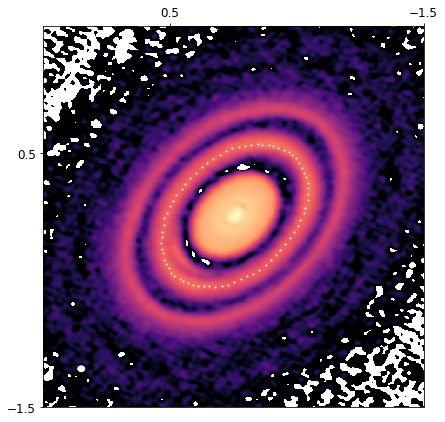

In [5]:
f = plt.figure(figsize=(7,7))
LBmap = plt.subplot(111, aspect = 'equal', adjustable = 'box')
cont.plot_cont_intensity(LBmap, 3, cmap ='magma', vmin = 3.e-2)
plt.scatter(xring,yring, s = 1, color = 'white')
plt.show()

In [6]:
def lnlike(ellipse_params, coords):
    """
    Parameters
    ==========
    ellipse_params: Tuple of ellipse parameters to fit for: x0, y0, r0, cosi, par, logvar
                    x0: x-offset in arcsec (Eastward offset is positive)
                    y0: y-offset in arcsec (Northward offset is positive)
                    r0: Radius of deprojected ring (arcsec)
                    cosi: Cosine of inclination
                    par: Position angle in radians (measured east of north)
                    logvar: Logarithm of variance of orthogonal distance from true ellipse (variance in arcsec^2)
    
    coords: Array of dimension (N,2), where N corresponds to the number of datapoints and the columns correspond
            to the x and y coordinates, respectively (in arcseconds)
    
    Returns
    =======
    Log-likelihood of the data given the ellipse model
    """
    x,y = coords
    x0, y0, r0, cosi, par, logvar = ellipse_params
    a = r0
    b = r0*cosi
    theta = par-np.pi/2.
    A = (np.cos(theta)/a)**2+(np.sin(theta)/b)**2
    B = -2*np.cos(theta)*np.sin(theta)/a**2+2*np.cos(theta)*np.sin(theta)/b**2
    C = (np.sin(theta)/a)**2+(np.cos(theta)/b)**2
 
    e0 = B**2-4*A*C #scalar
    e1 = 2*B*e0 #scalar
    e2 = 2*C*e0*(y-y0) #vector
    e3 = 4*B*C #scalar
    e4 = B**2+4*C**2+e0 #scalar
    e5 = 2*C*(B*(y-y0)-2*C*(x-x0)) #vector
    f4 = e1**2-e0*e4**2 #scalar
    f3 = 2*e1*e2-2*e0*e4*e5 #vector
    f2 = e2**2+2*e1*e3-e0*e5**2-4*e4**2*C #vector
    f1 = 2*e2*e3-8*e4*e5*C #vector
    f0 = e3**2-4*e5**2*C #vector
    sumdsq = 0 #sum of the squared orthogonal distances from the model ellipse
    #find the point p on the ellipse such that the tangent line is orthogonal to the line connecting p and the datapoint
    for i in range(len(x)):
        dmin = 1.e10
        #we get a fourth-order polynomial, but only one of the roots corresponds to the actual distance (the real root that minimizes the distance)
        roots = np.roots(np.array([f4, f3[i], f2[i], f1[i], f0[i]]))

        for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
            xi = (e1*dx**2+e2[i]*dx+e3)/(e4*dx+e5[i])
            dy = (-B*dx+xi)/(2*C)
            dist = np.sqrt((x[i]-x0-dx)**2+(y[i]-y0-dy)**2)
            if dist<dmin:
                dmin = dist       
        sumdsq+=dmin**2
    n = coords.shape[1]
    inv_sigma2 = 1.0/np.exp(logvar)
    return -0.5*(inv_sigma2*sumdsq - n*np.log(inv_sigma2))


#replace with appropriate priors
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -1<cosi<1 and 0 < par < np.pi and -12<logvar<-6:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, coords):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, coords)

The number of steps and the "burn-in" are chosen to demonstrate the code. You'll need to check for convergence for your own fits.

In [13]:
ndim, nwalkers = 6, 100

pos2 = [[0,0,0.6,np.cos(46.8*np.pi/180.),134*np.pi/180., np.log(.02**2)] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(np.row_stack([xring,yring]),), threads = 8)
sampler.run_mcmc(pos2, 1000)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/janehuan/anacond

(array([[ -5.41651394e-03,   7.50852936e-03,   6.63887784e-01,
           6.86849877e-01,   2.32370744e+00,  -1.10813964e+01],
        [ -6.24991153e-03,   7.42382063e-03,   6.63939073e-01,
           6.85640927e-01,   2.32332478e+00,  -1.05884388e+01],
        [ -5.58121488e-03,   7.18207653e-03,   6.64744651e-01,
           6.84768970e-01,   2.32828930e+00,  -1.07929018e+01],
        [ -4.23690607e-03,   6.82232067e-03,   6.62211501e-01,
           6.89621262e-01,   2.31951742e+00,  -1.08453236e+01],
        [ -4.90211694e-03,   6.95383191e-03,   6.66275401e-01,
           6.83619595e-01,   2.32729209e+00,  -1.06405212e+01],
        [ -5.51666192e-03,   6.32216124e-03,   6.64986082e-01,
           6.88314606e-01,   2.32040365e+00,  -1.05712157e+01],
        [ -6.14635975e-03,   7.05899843e-03,   6.63745020e-01,
           6.85564194e-01,   2.33506059e+00,  -1.07447027e+01],
        [ -6.19161974e-03,   7.30126019e-03,   6.64152894e-01,
           6.84373168e-01,   2.32462334e+00,  -1

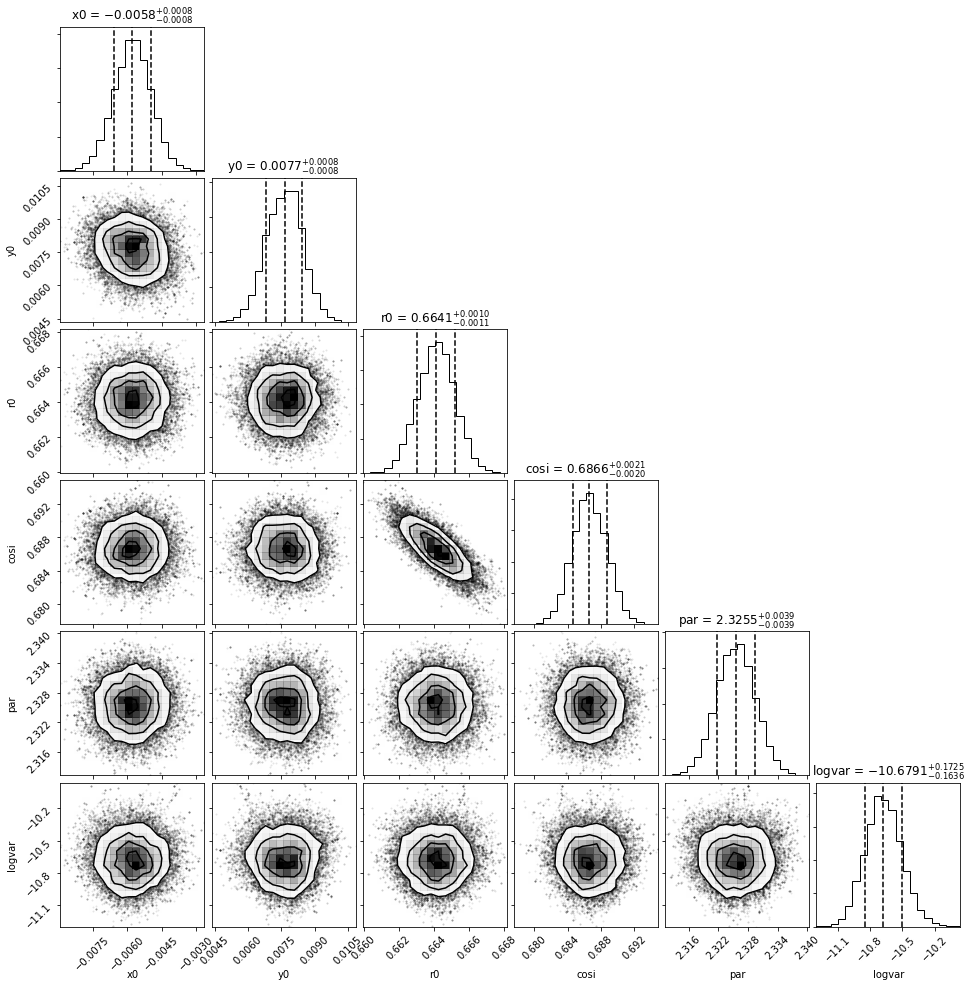

In [14]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))

fig = corner.corner(samples,  labels=["x0", "y0", "r0", "cosi", "par", "logvar"], quantiles = [0.16, 0.5, 0.84], show_titles = True, title_fmt = ".4f")
plt.show()

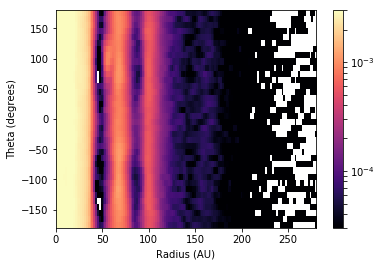

In [15]:
#check that PA and inclination are reasonable

cont = Continuum('/data/sandrews/ALMA_disks/final_images/HD163296_script_image.fits', 
                 -.0058,.0077, 2.3255*180/np.pi,np.arccos(.6866)*180/np.pi,  101)

radialbins = 1+2*np.arange(140)
surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.65, origin = 'lower', cmap = 'magma', norm = col.LogNorm(vmin = 3.e-5, vmax = 3.e-3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=280)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')